# Pediatric Bone Age Detection using Hand X-ray
Bone age is an indicator of skeletal maturity. A child’s bone age may or may not exactly match with the child’s age according to his or her birth date. Many factors, such as, nutrition, genetics, hormones, and disease states, influence the development of the skeletal [1]. The bone age study can tell how fast or slowly a child’s skeleton is maturing [2] and it can also provide useful information on many clinical concerns. Clinicians use bone age assessment in order to evaluate the maturity of a child’s skeletal system [3]. Applications that utilize assessment of the skeletal maturity are ever growing. In addition to the medical application, the skeletal maturity assessment can be used in sports selection and forensics to the international immigrant. For example, many children seeking asylum are required to undergo a bone age study so that required resources can be facilitated for them [1].

Data set provided in the [Pediatric Bone Age Challenge(2017)](https://www.rsna.org/en/education/ai-resources-and-training/ai-image-challenge/RSNA-Pediatric-Bone-Age-Challenge-2017) organized by the Radiological Society of North America (RSNA) are used for the child’s bone age prediction. The data set can be downloaded [here](https://stanfordmedicine.app.box.com/s/4r1zwio6z6lrzk7zw3fro7ql5mnoupcv) and includes
* 12,611 hand radiographs for training
* 1,425 hand radiographs for validation
* 200 hand radiographs for testing
* A CSV file with skeletal age estimates and sex of the training and validation images labeled from the accompanying clinical radiology report provided at the time of imaging, and a separate CSV file containing skeletal age estimates and sex of the test images.

#### References
[1] https://pediatrics.aappublications.org/content/140/6/e20171486

[2] https://kidshealth.org/en/parents/xray-bone-age.html

[3] Vladimir Iglovikov, Alexander Rakhlin, Alexandr A. Kalinin, Alexey Shvets “Pediatric Bone Age Assessment Using Deep Convolutional Neural Networks”, bioRxiv 234120


#### Model Inputs

* Child's hand radiography
* Child's gender information

#### Model Output
* Pediatric bone age prediction

#### Future-Work
* Train model with classification 'softmax' output layer and compare model's performace with regression model.
* Perform ensemble average of the models to improve model's performance.

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp # multiprocessing
import matplotlib.image as mpimg #image reading 
from matplotlib.cbook import flatten # flatten list

#### 1. **Data clean up and exploration**<br>
Read training and test CSV files. The train CSV contains three columns (id, boneage, and male) and 12,611 rows. The test CSV file contains two columns(Case ID and Sex) and 200 rows. None of the rows has null value.


In [2]:
# CSV file and iamge directories

# CSV file path + name
csv_train = '/storage/capstone_data/train.csv'
csv_valid = '/storage/capstone_data/validation.csv'
csv_test = '/storage/capstone_data/Bone-age-ground-truth.csv'

# Original data directory- before pre-processing (for image preprocessing)

train_img_pre = '/storage/capstone_data/train_image/'
valid_img_pre = '/storage/capstone_data/valid_image/'
test_img_pre = '/storage/capstone_data/test/test/'

# Save pre-processed images
train_save_dir = '/storage/capstone_data/train_preprocess/'
valid_save_dir = '/storage/capstone_data/valid_preprocess/'
test_save_dir = '/storage/capstone_data/test_preprocess/test/'

# Image data directories for model training
train_img_dir,valid_img_dir,test_img_dir = train_save_dir, valid_save_dir, test_save_dir

In [3]:
#loading dataframes
train_df = pd.read_csv(csv_train) #nrows = 12608)
valid_df = pd.read_csv(csv_valid)#nrows = 1408)
test_df = pd.read_csv(csv_test)

In [4]:
# Trian CSV file header
print (train_df.head())

     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False


In [5]:
# Validation CSV file header
print (valid_df.head())

   Image ID   male  Bone Age (months)
0      1386  False                 30
1      1392   True                162
2      1397  False                 18
3      1401  False                132
4      1410   True                 57


In [6]:
# Test CSV file header
print (test_df.head())

   Case ID Sex  Ground truth bone age (months)
0     4360   M                          168.93
1     4361   M                          169.65
2     4362   M                           73.26
3     4363   M                          152.86
4     4364   M                          135.46


In [7]:
# train CSV file info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12611 entries, 0 to 12610
Data columns (total 3 columns):
id         12611 non-null int64
boneage    12611 non-null int64
male       12611 non-null bool
dtypes: bool(1), int64(2)
memory usage: 209.5 KB


In [8]:
# Valid CSV file info
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 3 columns):
Image ID             1425 non-null int64
male                 1425 non-null bool
Bone Age (months)    1425 non-null int64
dtypes: bool(1), int64(2)
memory usage: 23.8 KB


In [9]:
# Test CSV file info
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
Case ID                           200 non-null int64
Sex                               200 non-null object
Ground truth bone age (months)    200 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ KB


#### Create image file names by appending '.png' file extension to the id column

In [10]:
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
valid_df['Image ID'] = valid_df['Image ID'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 
train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


In [11]:
valid_df.head()

,Image ID,male,Bone Age (months)
0,1386.png,False,30
1,1392.png,True,162
2,1397.png,False,18
3,1401.png,False,132
4,1410.png,True,57


**Some EDA- finding out male and female populaiton**

0    6833
1    5778
Name: Gender, dtype: int64


Text(0.5, 1.0, 'Male(0) and Female(1) count')

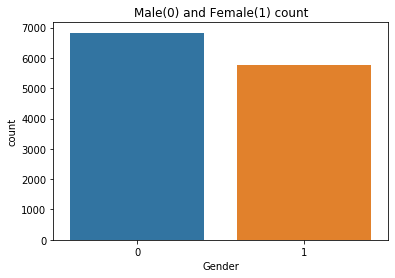

In [12]:
train_df['Gender'] = train_df['male'].apply(lambda x: 0 if x else 1)
valid_df['Gender'] = valid_df['male'].apply(lambda x: 0 if x else 1)
test_df['Gender'] = test_df['Sex'].apply(lambda x: 0 if x=='M' else 1)
test_df.rename(columns={'Ground truth bone age (months)': 'Age(months)'}, inplace=True)
print(train_df['Gender'].value_counts())
sns.countplot(x = train_df['Gender'])
plt.title('Male(0) and Female(1) count')

In [13]:
# train_df.head()
test_df.head()

,Case ID,Sex,Age(months),Gender
0,4360.png,M,168.93,0
1,4361.png,M,169.65,0
2,4362.png,M,73.26,0
3,4363.png,M,152.86,0
4,4364.png,M,135.46,0


In [14]:
# Feature normalization- total population
mean_age = train_df.boneage.mean()
std_age = train_df.boneage.std()
train_df['scale_bone_age_z'] = (train_df['boneage'] - mean_age)/(std_age)
valid_df['scale_bone_age_z'] = (valid_df['Bone Age (months)'] - mean_age)/(std_age)
train_df.head()

,id,boneage,male,Gender,scale_bone_age_z
0,1377.png,180,False,1,1.279181
1,1378.png,12,False,1,-2.800269
2,1379.png,94,False,1,-0.809109
3,1380.png,120,True,0,-0.177766
4,1381.png,82,False,1,-1.100498


Text(0.5, 1.0, '# of children vs age')

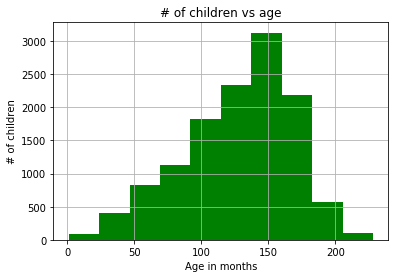

In [15]:
# Plotting a histogram for train bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('# of children')
plt.title('# of children vs age')

Text(0.5, 1.0, '# of children vs bone age z score')

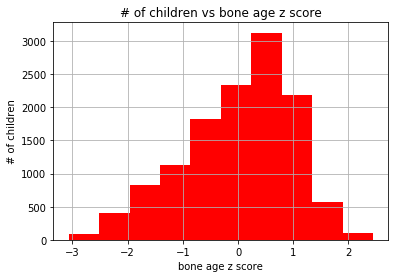

In [16]:
# Plotting a histogram for train bone ages (z-score)
train_df['scale_bone_age_z'].hist(color = 'red')
plt.xlabel('bone age z score')
plt.ylabel('# of children')
plt.title('# of children vs bone age z score')

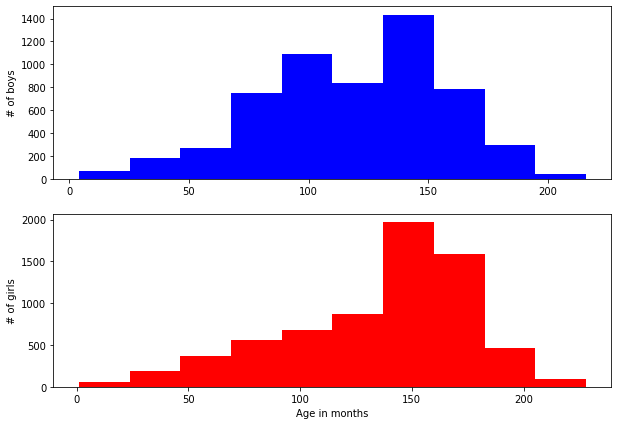

In [17]:
# Distribution of age within each gender 
male = train_df[train_df['Gender'] == 1]
female = train_df[train_df['Gender'] == 0]
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue')
ax[0].set_ylabel('# of boys')
ax[1].hist(female['boneage'], color = 'red')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('# of girls')
fig.set_size_inches((10,7))

### 2. Upload and Check if any training/validation image is corrupted or missing
#### --->Uncomment next two cells for the first time and comment back when images are verified

In [18]:
# import matplotlib.image as mpimg
# import os.path
# for filename, boneage, gender in train_df[['id','boneage','Sex']].values:
#     if not os.path.isfile(train_img_dir + filename): 
#         print ('This file does not exist-' + filename)
#     else:
#         try: img = mpimg.imread(train_img_dir + filename)
#         except OSError: print (filename)            

In [19]:
# Check if any valid image file is corrupted or missing

# for filename, boneage, gender in valid_df[['Image ID','Bone Age (months)','Sex']].values:
#     if not os.path.isfile(valid_img_dir + filename): 
#         print ('This file does not exist-' + filename)
#     else:
#         try: img = mpimg.imread(valid_img_dir + filename)
#         except OSError: print (filename)

### 3. Image preprocessing using Kmeans clustering (two iterations)
One iteration was not sufficient to remove all background noises. Therefore, two iterations were used for the preprocessing. Pre-processed images are saved in different directory from the original images. So, cells belongs to pre-processing are not required to run every single time. Comment next few cells releated to pre-processing after pre-processing is done for the first time.

1. Orignal image height is reduced to 2*image_size and width is also reduced to keep the same aspect ratio.
2. Image pixels are classified in n cluters (defined by n_clusters below) using K-means clustering.
3. Pixels from first four clusters are included to creat a mask. Only clusters meeting total pixel counts defined below are included.
4. Image is cropped to include only the mask region and then zero paded to make it square.
5. Image (height and width) is resized to 2*image_size to get similar size image as in step 2 so that same pixel count requirment
works for the second iteration.
6. Step 2-4 are repeated.
7. Image (height and width) is resized to image_size.

In [20]:
# Import required modules=====================
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from PIL import Image
import timeit
#============================================

In [21]:
# Input parameters============================
n_clusters = 6 #4
image_size = 256

In [22]:
def image_segmentain(img_flat):

  kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(img_flat.reshape(-1,1))  
  """Kmeans lables had issue with masking so center of each cluster
    is assigned for corresponding labels"""
    
  kmeans_centers = kmeans.cluster_centers_[kmeans.labels_]
  
  return  kmeans_centers.flatten()

In [23]:
def image_mask(kmeans_labels, img_gray_orig):

  mask_img = np.zeros((img_gray_orig.shape[0], img_gray_orig.shape[1]))
  kmeans_labels_arr = kmeans_labels.reshape(img_gray_orig.shape[0], img_gray_orig.shape[1])
    
  sort_labels = sorted(pd.Series(kmeans_labels).unique(), reverse = True)
  just_bone = ()
   
  if (np.sum(kmeans_labels_arr==sort_labels[0])) > 8000:
        just_bone = np.where(kmeans_labels_arr==sort_labels[0])
        mask_img[just_bone] = 1
#         print('test1')
                
  if (np.sum(kmeans_labels_arr==sort_labels[1])) > 8000 and (np.sum(kmeans_labels_arr==sort_labels[1])) < 60000:
        just_bone = np.where(kmeans_labels_arr==sort_labels[1])
        mask_img[just_bone] = 1
#         print('test2')
  if (np.sum(kmeans_labels_arr==sort_labels[2]))>8000 and (np.sum(kmeans_labels_arr==sort_labels[2])) < 70000:
        just_bone = np.where(kmeans_labels_arr==sort_labels[2])
        mask_img[just_bone] = 1
#         print('test3')
  if (np.sum(kmeans_labels_arr==sort_labels[3]))>8000 and (np.sum(kmeans_labels_arr==sort_labels[3])) < 70000:
        just_bone = np.where(kmeans_labels_arr==sort_labels[3])
        mask_img[just_bone] = 1
#         print('test4')
  if not just_bone:
    just_bone = np.where(kmeans_labels_arr==sort_labels[1]) 
    mask_img[just_bone] = 1
#     print('test4')

#   plt.imshow(mask_img)
#   plt.show()
  return just_bone, mask_img


In [24]:
def img_resize(img, img_height):

  img_width  = int(img_height*img.shape[1]/img.shape[0])

  img_pil = Image.fromarray(img) # convert array back to image
  
  img_pil_resize = img_pil.resize((img_width, img_height), Image.LANCZOS) # resize

  return np.array(img_pil_resize)

In [25]:
def img_pad_resize(img_just_bone, image_size):

  
  size_diff = img_just_bone.shape[0]-img_just_bone.shape[1]

  if size_diff > 0: # hieght is longer than width
    top = 0
    bottom = 0
    left = int(abs(size_diff)/2.)
    right = (abs(size_diff)-left)
  elif size_diff < 0: # hieght is shorter than width
    left = 0
    right = 0
    top = int(abs(size_diff)/2.)
    bottom = (abs(size_diff)-top)
  else:
    top = 0
    bottom = 0
    left = 0
    right = 0

  img_bone_square = np.pad (img_just_bone,((top,bottom),(left,right)), 'constant')

  img_bone = img_resize(img_bone_square, image_size)
    
#   plt.imshow(img_bone)
#   plt.show()
  
  return img_bone

In [26]:
def img_preprocess_core(img_gray_orig):
    
    img_flat = img_gray_orig.reshape(img_gray_orig.shape[0] * img_gray_orig.shape[1])
         
    kmeans_labels =  image_segmentain(img_flat)
    
    kmeans_labels_arr = kmeans_labels.reshape(img_gray_orig.shape[0], img_gray_orig.shape[1])

    just_bone, mask_img = image_mask (kmeans_labels, img_gray_orig)
       
    img_clean_background = mask_img * img_gray_orig

    img_just_bone = img_clean_background[min(just_bone[0]):max(just_bone[0]),\
                                         min(just_bone[1]):max(just_bone[1])]
    return img_just_bone

In [27]:
def img_preprocessing(save_path,img_path, filename):
       
    save_path_filename = save_path + filename
   
    image = plt.imread(img_path + filename)
    img_gray_orig_0 = rgb2gray(image)
    
#     plt.imshow(img_gray_orig_0)
#     plt.show()
    img_gray_orig = img_resize(img_gray_orig_0, 2*image_size)
    
    img_just_bone = img_preprocess_core(img_gray_orig)
    
    try:
        img_bone = img_pad_resize(img_just_bone, 2*image_size) 
         #Second iteration of image segmentation
        img_just_bone = img_preprocess_core(img_bone)
        img_bone = img_pad_resize(img_just_bone, image_size)

        plt.imsave(save_path_filename, img_bone)
        
    except ValueError:
        print (filename)
    
#     print (sorted(pd.Series(kmeans_labels).unique(), reverse = True))
#     print (pd.Series(kmeans_labels).value_counts())       


#### Multiprocessing model to speed up the preprocessing
##### Pre-processing train images

In [28]:
# def multi_run_wrapper(args):
#    return img_preprocessing(*args)

# def main():
 
#   pool = mp.Pool(mp.cpu_count())
#   result = pool.map(multi_run_wrapper,[(train_save_dir,train_img_pre, fname) for fname in train_df['id'].values])

# if __name__ == "__main__":
#     start = timeit.default_timer()
#     main()
    
#     stop = timeit.default_timer()
#     print('Time in (sec): ', stop - start)  

##### Pre-processing validation images

In [29]:
# def multi_run_wrapper(args):
#    return img_preprocessing(*args)

# def main():
 
#   pool = mp.Pool(mp.cpu_count())
#   result = pool.map(multi_run_wrapper,[(valid_save_dir,valid_img_pre, fname) for fname in valid_df['Image ID'].values])

# if __name__ == "__main__":
#     start = timeit.default_timer()
#     main()
    
#     stop = timeit.default_timer()
#     print('Time in (sec): ', stop - start)

#####  Pre-processing test images    

In [30]:
# def multi_run_wrapper(args):
#    return img_preprocessing(*args)

# def main():
 
#   pool = mp.Pool(mp.cpu_count())
#   result = pool.map(multi_run_wrapper,[(test_save_dir, test_img_pre, fname) for fname in test_df['Case ID'].values])

# if __name__ == "__main__":
#     start = timeit.default_timer()
#     main()
    
#     stop = timeit.default_timer()
#     print('Time in (sec): ', stop - start)

##### Without multiprocessing (serial operation)

In [31]:
# start = timeit.default_timer()
# save_dir = '/storage/capstone_data/'
# test_img = '/storage/capstone_data/test/test/'
# for fname in ['4360.png']:#train_df['id'].values[0:16]:
#     img_preprocessing(save_dir, test_img, fname)

# stop = timeit.default_timer()
# print('Time in (sec): ', stop - start) 

### 4. Visual inspection of some sample images

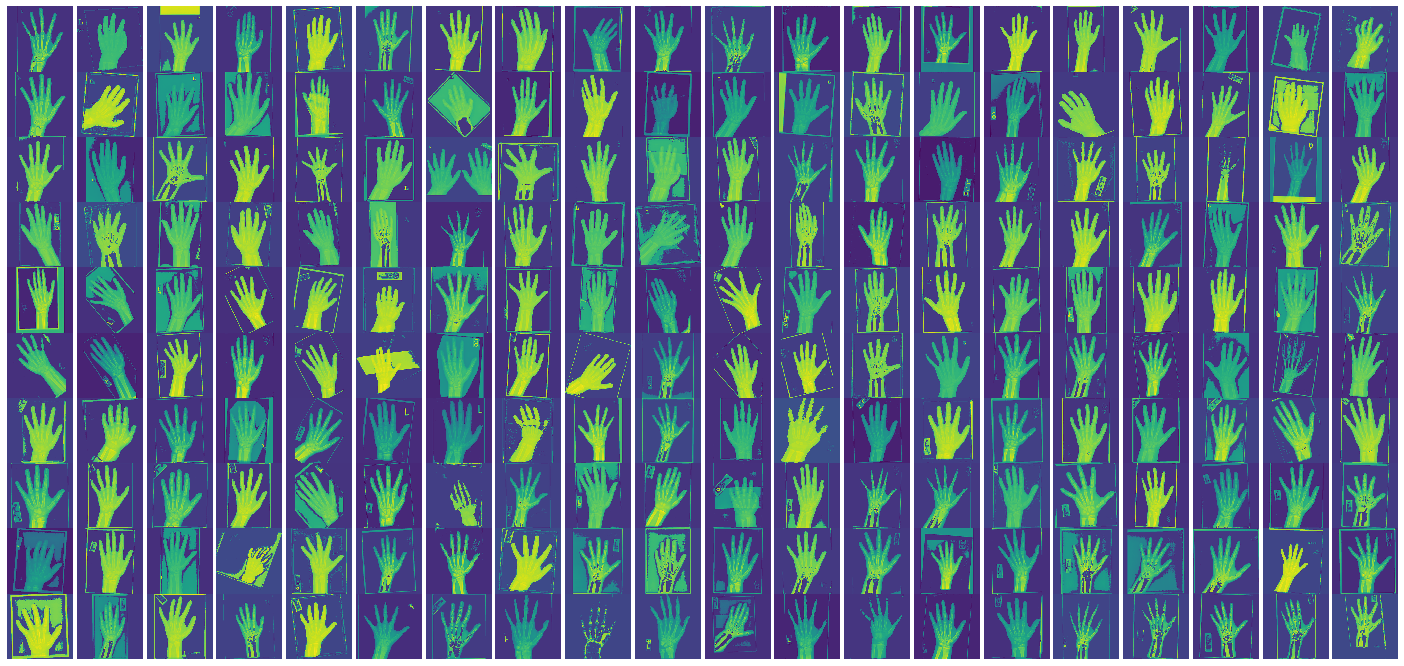

In [32]:
# Display some train images
fig, axs = plt.subplots(10,20, figsize=(25,12), facecolor='w', edgecolor='k')
plt_num =0
axs = axs.ravel()

for filename in train_df['id'][0:200].values:
    img = mpimg.imread(train_img_dir + filename)
    
    axs[plt_num].imshow(rgb2gray(img))
#     axs[plt_num].set_title('file:{}'.format(filename))
    axs[plt_num].set_axis_off()
    plt_num += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

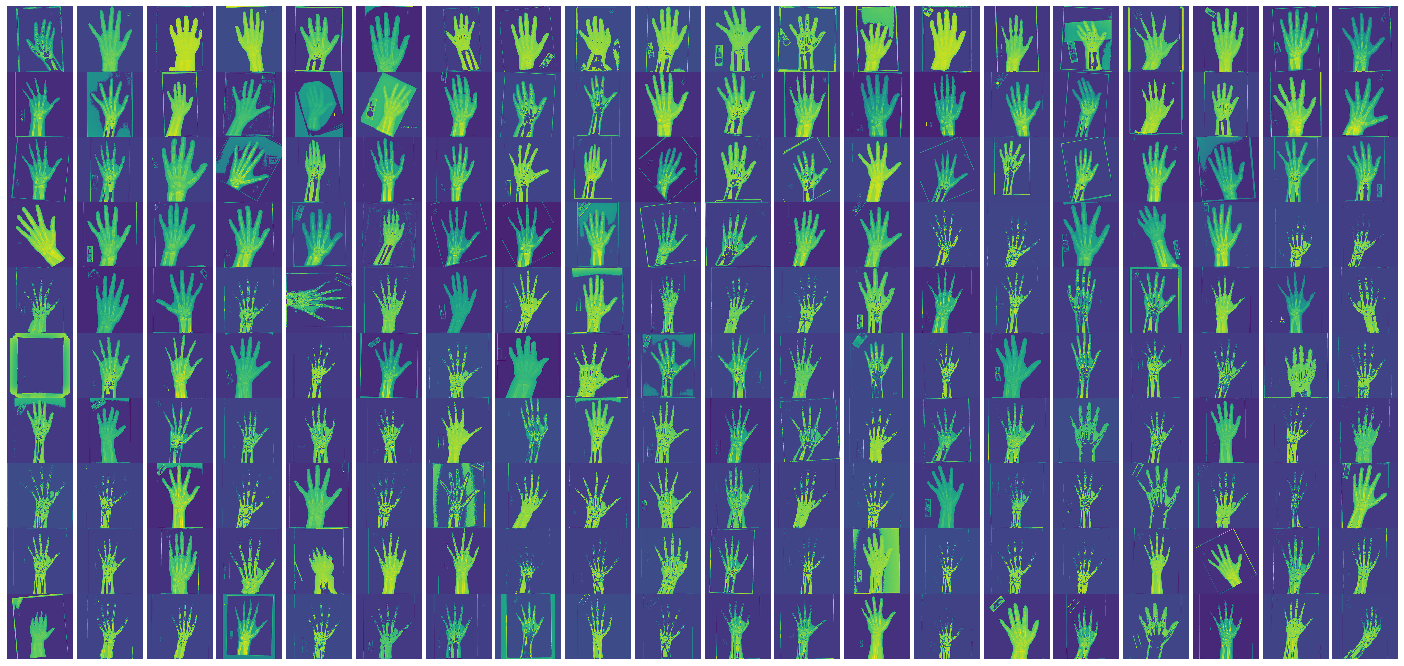

In [33]:
# Display some validation images
fig, axs = plt.subplots(10,20, figsize=(25,12), facecolor='w', edgecolor='k')
plt_num =0
axs = axs.ravel()

for filename in valid_df['Image ID'][0:200].values:
    img = mpimg.imread(valid_img_dir + filename)
    
    axs[plt_num].imshow(rgb2gray(img))
#     axs[plt_num].set_title('file:{}'.format(filename))
    axs[plt_num].set_axis_off()
    plt_num += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

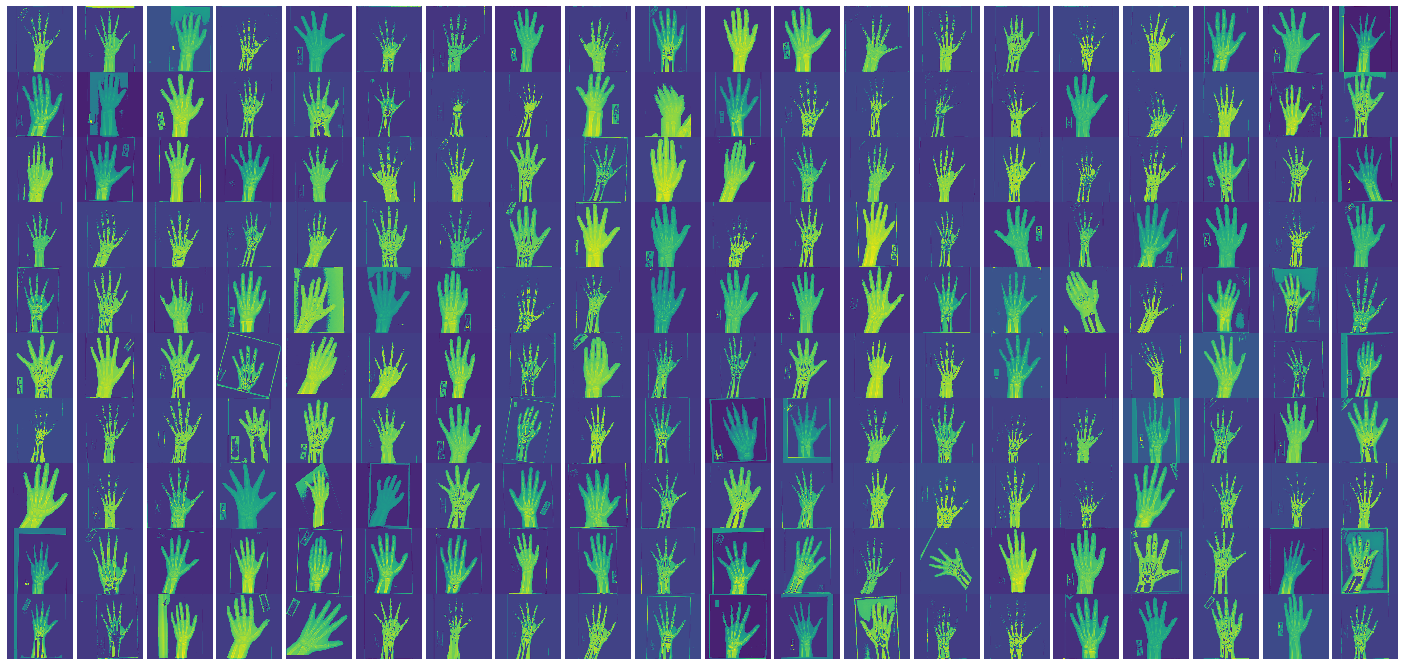

In [34]:
# Display some test images
fig, axs = plt.subplots(10,20, figsize=(25,12), facecolor='w', edgecolor='k')
plt_num =0
axs = axs.ravel()

for filename in test_df['Case ID'][0:200].values:
    img = mpimg.imread(test_img_dir + filename)
#     img = mpimg.imread(test_img_dir + filename)
    
    axs[plt_num].imshow(rgb2gray(img))
#     axs[plt_num].set_title('file:{}'.format(filename))
    axs[plt_num].set_axis_off()
    plt_num += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [35]:
import tensorflow
tensorflow.__version__

'2.4.0'

In [36]:
from tensorflow.keras.metrics import mean_absolute_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten, Dropout, Conv2D,Input,concatenate
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

**Setting up Image Data Generators!**<br>
Image data generator was used for both training, validation, and testing of the model. 

In [37]:
def plot_it(history):
    '''Plots training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae in months'])
    ax.plot(history.history['val mae in months'])
    plt.title('Model Error')
    plt.ylabel('mae error')
    plt.xlabel('Epoch #')
    plt.legend(['Train', 'Valid'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [38]:
def mae_in_months(x_p, y_p):
    '''Calculates mae in months'''
    mae = mean_absolute_error((std_age*x_p + mean_age), (std_age*y_p + mean_age)) 
    return mae

#### Image data generator

In [39]:
def image_data_gen(imgDatGen, train_img_dir, df, batch_size, seed, img_size, X_COL):
    
    gen_img = imgDatGen.flow_from_dataframe(dataframe=df,
                                            directory= train_img_dir,
                                            x_col= X_COL,
                                            y_col='scale_bone_age_z',                                            
                                            batch_size=batch_size,
                                            seed=seed,
                                            shuffle=True,
                                            class_mode='raw',
                                            target_size=(img_size, img_size),
                                            color_mode='rgb')
    
    gen_gender = imgDatGen.flow_from_dataframe(dataframe=df,
                                               directory = train_img_dir,
                                               x_col=X_COL,
                                               y_col='Gender',
                                               batch_size=batch_size,
                                               seed=seed,
                                               shuffle=True,
                                               class_mode='raw', 
                                               target_size=(img_size, img_size),
                                               color_mode='rgb')
    return gen_img, gen_gender

In [40]:
def gen_2inputs(gen_img, gen_gender):
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

In [41]:
img_size = 256
BATCH_SIZE = 32
SEED = 42
train_idg = ImageDataGenerator(zoom_range=0.2,
                               fill_mode='nearest',
                               rotation_range=25,  
                               width_shift_range=0.25,  
                               height_shift_range=0.25,  
                               vertical_flip=False, 
                               horizontal_flip=True,
                               shear_range = 0.2,
                               samplewise_center=False, 
                               samplewise_std_normalization=False)

val_idg = ImageDataGenerator(width_shift_range=0.25,
                             height_shift_range=0.25,
                             horizontal_flip=True)

test_data_generator = ImageDataGenerator()
test_generator = test_data_generator.flow_from_directory(directory = test_img_dir,
                                                         batch_size= 200,
                                                          shuffle = False,
                                                          class_mode = None,
                                                           color_mode = 'rgb',
                                                            target_size = (img_size,img_size))

Found 3 images belonging to 1 classes.


In [42]:
train_gen_img, train_gen_gender = image_data_gen(train_idg,
                                                 train_img_dir,
                                                 train_df,
                                                 BATCH_SIZE,
                                                 SEED,
                                                 img_size,
                                                 'id')
train_flow = gen_2inputs(train_gen_img, train_gen_gender)

valid_gen_img, valid_gen_gender = image_data_gen(val_idg,
                                                 valid_img_dir,
                                                 valid_df,
                                                 BATCH_SIZE,
                                                 SEED, img_size,
                                                 'Image ID')
valid_flow = gen_2inputs(valid_gen_img, valid_gen_gender)   

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Found 1425 validated image filenames.
Found 1425 validated image filenames.


In [43]:
STEP_SIZE_TRAIN = train_gen_img.n//train_gen_img.batch_size
STEP_SIZE_VALID = valid_gen_img.n//valid_gen_img.batch_size
STEP_SIZE_TEST  = test_generator.n//test_generator.batch_size
print (STEP_SIZE_TRAIN, STEP_SIZE_VALID,STEP_SIZE_TEST )

394 44 0


In [44]:
test_gen_img, test_gen_gender = image_data_gen(val_idg,
                                                 valid_img_dir,
                                                 valid_df,
                                                 1024,
                                                 SEED, img_size,
                                                 'Image ID')
test_X, test_Y  =  next(gen_2inputs(test_gen_img, test_gen_gender))
print(test_X[0].shape, test_X[1].shape)

Found 1425 validated image filenames.
Found 1425 validated image filenames.
(1024, 256, 256, 3) (1024,)


#### Construct a model with image and gender inputs and one output (age)

In [45]:
input_tensor = Input(shape=(img_size,img_size,3) )
x = tf.keras.applications.xception.Xception(include_top = False,
                                           weights = 'imagenet')(input_tensor)
x.trainable = True
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Model(inputs=input_tensor, outputs=x)

#second input
input_sex = Input(shape=(1,))
y = Dense(32, activation="relu")(input_sex)
y = Model(inputs=input_sex, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(1000, activation = 'relu')(combined) # changed from 10 to 64
z = Dropout(0.3)(z)
z = Dense(1000, activation = 'relu')(z) # added
z = Dropout(0.3)(z)
z = Dense(1, activation="linear")(z)
# This model accepts the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

#compile model
model.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

#model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, None, None, 2 20861480    input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           xception[0][0]                   
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [46]:
#save model in json format
model_json = model.to_json()
with open("model_test.json", "w") as json_file:
    json_file.write(model_json)

#### Train Model

In [47]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')

mc = ModelCheckpoint('modle_test.h5', monitor='val_loss', mode='min', save_best_only=True)

red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks = [early_stopping,mc, red_lr_plat]

# fit
history = model.fit(train_flow,
                            steps_per_epoch = STEP_SIZE_TRAIN,
                            validation_data = valid_flow,
                            validation_steps = STEP_SIZE_VALID,
                            epochs = 2,
                            callbacks= callbacks)

history
pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)
plot_it(history)

#### Load model, history and model.h5

In [48]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten

In [49]:
history = pd.read_csv('history.csv')
history.head()

,loss,mae_in_months,val_loss,val_mae_in_months,lr
0,0.581214,23.024183,0.235803,15.786109,0.001
1,0.181708,13.264579,0.292625,18.325399,0.001


In [50]:
history[['mae_in_months','val_mae_in_months']].plot();

In [51]:
# opening and store file in a variable
with open("model.json", "r") as json_file:
    loaded_model_json = json_file.read()

#model_from_json to make a loaded model
model = tensorflow.keras.models.model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("model.h5")
model.compile(loss = 'mse', optimizer = 'adam', metrics = [mae_in_months] )

#### Predicting on validation data

In [52]:
# model.load_weights('.h5')
valid_pred = mean_age + std_age*(model.predict(test_X, batch_size = 32, verbose = True))
valid_actual = mean_age + std_age*(test_Y)

32/32 [==============================] - 106s 3s/step


Text(0, 0.5, 'Predicted Age (Months)')

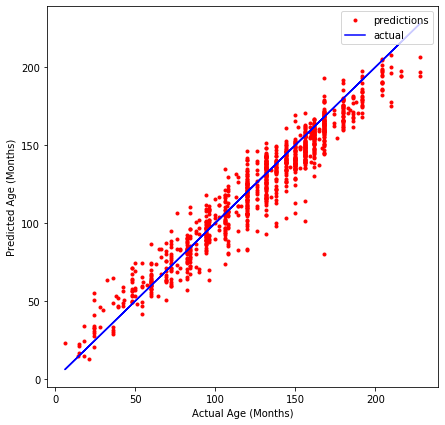

In [53]:
# Plot- precitons vs actual age using validation data
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(valid_actual, valid_pred, 'r.', label = 'predictions')
ax.plot(valid_actual, valid_actual, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

In [54]:
print('Mean absolute distance of the validation images: {} months'.format(round(np.mean(abs(valid_actual-list(flatten(valid_pred)))),1)))

Mean absolute distance of the validation images: 9.3 months


Text(0, 0.5, 'Frequencey')

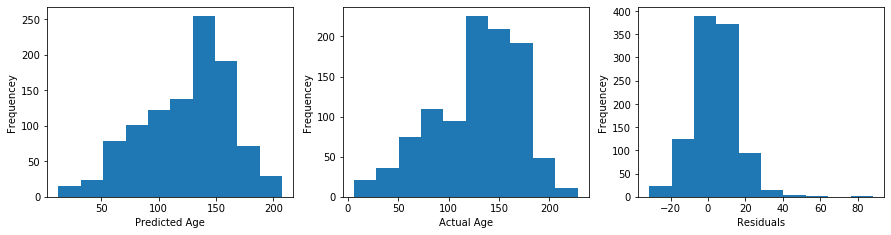

In [55]:
valid_pred_flat = list(flatten(valid_pred)) 
valid_pred_flat = (valid_actual-valid_pred_flat)
fig, axes = plt.subplots(figsize=(15, 3.5), nrows=1, ncols=3)
axes[0].hist(valid_pred);
axes[0].set_xlabel("Predicted Age")
axes[0].set_ylabel("Frequencey")
axes[1].hist(valid_actual);
axes[1].set_xlabel("Actual Age")
axes[1].set_ylabel("Frequencey")
axes[2].hist(valid_pred_flat);
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Frequencey")

### Predict on test images 

In [60]:
def test_gen_2inputs(imgDatGen, train_img_dir, df, batch_size, seed, img_size, X_COL):
    
    gen_img = imgDatGen.flow_from_dataframe(dataframe=df,
                                            directory= train_img_dir,
                                            x_col= X_COL,
                                            y_col='Age(months)',                                            
                                            batch_size=batch_size,
                                            seed=seed,
                                            shuffle=True,
                                            class_mode='raw',
                                            target_size=(img_size, img_size),
                                            color_mode='rgb')
    
    gen_gender = imgDatGen.flow_from_dataframe(dataframe=df,
                                               directory = train_img_dir,
                                               x_col=X_COL,
                                               y_col='Gender',
                                               batch_size=batch_size,
                                               seed=seed,
                                               shuffle=True,
                                               class_mode='raw', 
                                               target_size=(img_size, img_size),
                                               color_mode='rgb')
    return gen_img, gen_gender

In [61]:
val_idg_2 = ImageDataGenerator()
valid_gen_img_2, valid_gen_gender_2 = test_gen_2inputs(val_idg_2,
                                                 "/storage/capstone_data/test_preprocess/test/",
                                                 test_df,
                                                 200,
                                                 42, 256,
                                                 'Case ID')
test_flow = gen_2inputs(valid_gen_img_2, valid_gen_gender_2)

Found 200 validated image filenames.
Found 200 validated image filenames.


In [62]:
test_XX, test_YY = next(test_flow)

In [64]:
#Predict age from test images
y_pred = model.predict(test_XX, batch_size = 200, verbose = True)
predicted = y_pred.flatten()
predicted_months = mean_age + std_age*(predicted)

1/1 [==============================] - 22s 22s/step


In [65]:
print('Mean absolute distance of the validation images: {} months'.format(round(np.mean(abs(test_YY-list(flatten(predicted_months)))),1)))

Mean absolute distance of the validation images: 8.2 months


Text(0, 0.5, 'Predicted Age (Months)')

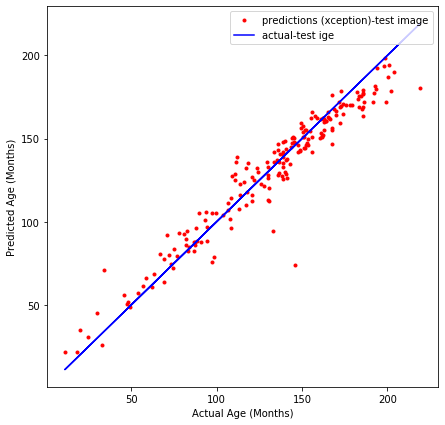

In [66]:
# PLot-actual vs predicted age from test image
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_YY, predicted_months, 'r.', label = 'predictions (xception)-test image')
ax.plot(test_YY, test_YY, 'b-', label = 'actual-test ige')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')